In [1]:
#| default_exp common._scalers

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# TemporalNorm

> Temporal normalization has proven to be essential in neural forecasting tasks, as it enables network's non-linearities to express themselves. Forecasting scaling methods take particular interest in the temporal dimension where most of the variance dwells, contrary to other deep learning techniques like `BatchNorm` that normalizes across batch and temporal dimensions, and `LayerNorm` that normalizes across the feature dimension. Currently we support the following techniques: `std`, `median`, `norm`, `norm1`, `invariant`. <br><br>

![Figure 1. Illustration of temporal normalization (left), layer normalization (center) and batch normalization (right). The entries in green show the components used to compute the normalizing statistics.](imgs_models/temporal_norm.png)

In [3]:
#| export
import torch
import torch.nn as nn

In [4]:
#| hide
from nbdev.showdoc import show_doc
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"]=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams["figure.figsize"] = (4,2)

# <span style="color:DarkBlue"> 1. Auxiliary Functions </span>

In [5]:
#| export
def masked_median(x, mask, dim=-1, keepdim=True):
    """ Masked Median

    Compute the median of tensor `x` along dim, ignoring values where 
    `mask` is False. `x` and `mask` need to be broadcastable.

    **Parameters:**<br>
    `x`: torch.Tensor to compute median of along `dim` dimension.<br>
    `mask`: torch Tensor bool with same shape as `x`, where `x` is valid and False
            where `x` should be masked. Mask should not be all False in any column of
            dimension dim to avoid NaNs from zero division.<br>
    `dim` (int, optional): Dimension to take median of. Defaults to -1.<br>
    `keepdim` (bool, optional): Keep dimension of `x` or not. Defaults to True.<br>

    **Returns:**<br>
    `x_median`: torch.Tensor with normalized values.
    """
    x_nan = x.float().masked_fill(mask<1, float("nan"))
    x_median, _ = x_nan.nanmedian(dim=dim, keepdim=keepdim)
    return x_median

def masked_mean(x, mask, dim=-1, keepdim=True):
    """ Masked  Mean

    Compute the mean of tensor `x` along dimension, ignoring values where 
    `mask` is False. `x` and `mask` need to be broadcastable.

    **Parameters:**<br>
    `x`: torch.Tensor to compute mean of along `dim` dimension.<br>
    `mask`: torch Tensor bool with same shape as `x`, where `x` is valid and False
            where `x` should be masked. Mask should not be all False in any column of
            dimension dim to avoid NaNs from zero division.<br>
    `dim` (int, optional): Dimension to take mean of. Defaults to -1.<br>
    `keepdim` (bool, optional): Keep dimension of `x` or not. Defaults to True.<br>

    **Returns:**<br>
    `x_mean`: torch.Tensor with normalized values.
    """
    x_nan = x.float().masked_fill(mask<1, float("nan"))
    x_mean = x_nan.nanmean(dim=dim, keepdim=keepdim)
    return x_mean

In [6]:
show_doc(masked_median, title_level=3)

---

### masked_median

>      masked_median (x, mask, dim=-1, keepdim=True)

Masked Median

Compute the median of tensor `x` along dim, ignoring values where 
`mask` is False. `x` and `mask` need to be broadcastable.

**Parameters:**<br>
`x`: torch.Tensor to compute median of along `dim` dimension.<br>
`mask`: torch Tensor bool with same shape as `x`, where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>
`dim` (int, optional): Dimension to take median of. Defaults to -1.<br>
`keepdim` (bool, optional): Keep dimension of `x` or not. Defaults to True.<br>

**Returns:**<br>
`x_median`: torch.Tensor with normalized values.

In [7]:
show_doc(masked_mean, title_level=3)

---

### masked_mean

>      masked_mean (x, mask, dim=-1, keepdim=True)

Masked  Mean

Compute the mean of tensor `x` along dimension, ignoring values where 
`mask` is False. `x` and `mask` need to be broadcastable.

**Parameters:**<br>
`x`: torch.Tensor to compute mean of along `dim` dimension.<br>
`mask`: torch Tensor bool with same shape as `x`, where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>
`dim` (int, optional): Dimension to take mean of. Defaults to -1.<br>
`keepdim` (bool, optional): Keep dimension of `x` or not. Defaults to True.<br>

**Returns:**<br>
`x_mean`: torch.Tensor with normalized values.

# <span style="color:DarkBlue"> 2. Scalers </span>

In [8]:
#| export
def minmax_scaler(x, mask, eps=1e-6, dim=-1):
    """ MinMax Scaler

    Standardizes temporal features by ensuring its range dweels between
    [0,1] range. This transformation is often used as an alternative 
    to the standard scaler. The scaled features are obtained as:

    $$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\mathrm{min}({\mathbf{x}})_{[B,1,C]})/
        (\mathrm{max}({\mathbf{x}})_{[B,1,C]}- \mathrm{min}({\mathbf{x}})_{[B,1,C]})$$

    **Parameters:**<br>
    `x`: torch.Tensor input tensor.<br>
    `mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
            where `x` should be masked. Mask should not be all False in any column of
            dimension dim to avoid NaNs from zero division.<br>
    `eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
    `dim` (int, optional): Dimension over to compute min and max. Defaults to -1.<br>

    **Returns:**<br>
    `z`: torch.Tensor same shape as `x`, except scaled.
    """
    max_mask = (mask==0) * (-1e12)
    min_mask = (mask==0) * (1e12)
    x_max = torch.max(x + max_mask, dim=dim, keepdim=True)[0]
    x_min = torch.min(x + min_mask, dim=dim, keepdim=True)[0]

    # x_range and prevent division by zero
    x_range = x_max - x_min
    x_range[x_range==0] = 1.0
    x_range = x_range + eps

    z = (x - x_min) / x_range
    return z, x_min, x_range

In [9]:
#| exporti
def inv_minmax_scaler(z, x_min, x_range):
    return z * x_range + x_min

In [10]:
show_doc(minmax_scaler, title_level=3)

---

### minmax_scaler

>      minmax_scaler (x, mask, eps=1e-06, dim=-1)

MinMax Scaler

Standardizes temporal features by ensuring its range dweels between
[0,1] range. This transformation is often used as an alternative 
to the standard scaler. The scaled features are obtained as:

$$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\mathrm{min}({\mathbf{x}})_{[B,1,C]})/
    (\mathrm{max}({\mathbf{x}})_{[B,1,C]}- \mathrm{min}({\mathbf{x}})_{[B,1,C]})$$

**Parameters:**<br>
`x`: torch.Tensor input tensor.<br>
`mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>
`eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
`dim` (int, optional): Dimension over to compute min and max. Defaults to -1.<br>

**Returns:**<br>
`z`: torch.Tensor same shape as `x`, except scaled.

In [11]:
#| export
def minmax1_scaler(x, mask, eps=1e-6, dim=-1):
    """ MinMax1 Scaler

    Standardizes temporal features by ensuring its range dweels between
    [-1,1] range. This transformation is often used as an alternative 
    to the standard scaler or classic Min Max Scaler. 
    The scaled features are obtained as:

    $$\mathbf{z} = 2 (\mathbf{x}_{[B,T,C]}-\mathrm{min}({\mathbf{x}})_{[B,1,C]})/ (\mathrm{max}({\mathbf{x}})_{[B,1,C]}- \mathrm{min}({\mathbf{x}})_{[B,1,C]})-1$$

    **Parameters:**<br>
    `x`: torch.Tensor input tensor.<br>
    `mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
            where `x` should be masked. Mask should not be all False in any column of
            dimension dim to avoid NaNs from zero division.<br>
    `eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
    `dim` (int, optional): Dimension over to compute min and max. Defaults to -1.<br>

    **Returns:**<br>
    `z`: torch.Tensor same shape as `x`, except scaled.
    """
    max_mask = (mask==0) * (-1e12)
    min_mask = (mask==0) * (1e12)
    x_max = torch.max(x + max_mask, dim=dim, keepdim=True)[0]
    x_min = torch.min(x + min_mask, dim=dim, keepdim=True)[0]

    # x_range and prevent division by zero
    x_range = x_max - x_min
    x_range[x_range==0] = 1.0
    x_range = x_range + eps

    x = (x - x_min) / x_range
    z = x * (2) - 1
    return z, x_min, x_range

In [12]:
#| exporti
def inv_minmax1_scaler(z, x_min, x_range):
    z = (z + 1) / 2
    return z * x_range + x_min

In [13]:
show_doc(minmax1_scaler, title_level=3)

---

### minmax1_scaler

>      minmax1_scaler (x, mask, eps=1e-06, dim=-1)

MinMax1 Scaler

Standardizes temporal features by ensuring its range dweels between
[-1,1] range. This transformation is often used as an alternative 
to the standard scaler or classic Min Max Scaler. 
The scaled features are obtained as:

$$\mathbf{z} = 2 (\mathbf{x}_{[B,T,C]}-\mathrm{min}({\mathbf{x}})_{[B,1,C]})/ (\mathrm{max}({\mathbf{x}})_{[B,1,C]}- \mathrm{min}({\mathbf{x}})_{[B,1,C]})-1$$

**Parameters:**<br>
`x`: torch.Tensor input tensor.<br>
`mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>
`eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
`dim` (int, optional): Dimension over to compute min and max. Defaults to -1.<br>

**Returns:**<br>
`z`: torch.Tensor same shape as `x`, except scaled.

In [14]:
#| export
def std_scaler(x, mask, dim=-1, eps=1e-6):
    """ Standard Scaler

    Standardizes features by removing the mean and scaling
    to unit variance along the `dim` dimension. 

    For example, for `base_windows` models, the scaled features are obtained as (with dim=1):

    $$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\\bar{\mathbf{x}}_{[B,1,C]})/\hat{\sigma}_{[B,1,C]}$$

    **Parameters:**<br>
    `x`: torch.Tensor.<br>
    `mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
            where `x` should be masked. Mask should not be all False in any column of
            dimension dim to avoid NaNs from zero division.<br>
    `eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
    `dim` (int, optional): Dimension over to compute mean and std. Defaults to -1.<br>

    **Returns:**<br>
    `z`: torch.Tensor same shape as `x`, except scaled.
    """
    x_means = masked_mean(x=x, mask=mask, dim=dim)
    x_stds = torch.sqrt(masked_mean(x=(x-x_means)**2, mask=mask, dim=dim))
    
    # Protect against division by zero
    x_stds[x_stds==0] = 1.0
    x_stds = x_stds + eps

    z = (x - x_means) / x_stds
    return z, x_means, x_stds

In [15]:
#| exporti
def inv_std_scaler(z, x_mean, x_std):
    return (z * x_std) + x_mean

In [16]:
show_doc(std_scaler, title_level=3)

---

### std_scaler

>      std_scaler (x, mask, dim=-1, eps=1e-06)

Standard Scaler

Standardizes features by removing the mean and scaling
to unit variance along the `dim` dimension. 

For example, for `base_windows` models, the scaled features are obtained as (with dim=1):

$$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\bar{\mathbf{x}}_{[B,1,C]})/\hat{\sigma}_{[B,1,C]}$$

**Parameters:**<br>
`x`: torch.Tensor.<br>
`mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>
`eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
`dim` (int, optional): Dimension over to compute mean and std. Defaults to -1.<br>

**Returns:**<br>
`z`: torch.Tensor same shape as `x`, except scaled.

In [17]:
#| export
def robust_scaler(x, mask, dim=-1, eps=1e-6):
    """ Robust Median Scaler

    Standardizes features by removing the median and scaling
    with the mean absolute deviation (mad) a robust estimator of variance.
    This scaler is particularly useful with noisy data where outliers can 
    heavily influence the sample mean / variance in a negative way.
    In these scenarios the median and amd give better results.
    
    For example, for `base_windows` models, the scaled features are obtained as (with dim=1):

    $$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\\textrm{median}(\mathbf{x})_{[B,1,C]})/\\textrm{mad}(\mathbf{x})_{[B,1,C]}$$
        
    $$\\textrm{mad}(\mathbf{x}) = \\frac{1}{N} \sum_{}|\mathbf{x} - \mathrm{median}(x)|$$

    **Parameters:**<br>
    `x`: torch.Tensor input tensor.<br>
    `mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
            where `x` should be masked. Mask should not be all False in any column of
            dimension dim to avoid NaNs from zero division.<br>
    `eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
    `dim` (int, optional): Dimension over to compute median and mad. Defaults to -1.<br>

    **Returns:**<br>
    `z`: torch.Tensor same shape as `x`, except scaled.
    """
    x_median = masked_median(x=x, mask=mask, dim=dim)
    x_mad = masked_median(x=torch.abs(x-x_median), mask=mask, dim=dim)

    # Protect x_mad=0 values
    x_means = masked_mean(x=x, mask=mask, dim=dim)
    x_stds = torch.sqrt(masked_mean(x=(x-x_means)**2, mask=mask, dim=dim))  
    x_mad_aux = x_stds / 0.6744897501960817
    x_mad = x_mad * (x_mad>0) + x_mad_aux * (x_mad==0)
    
    # Protect against division by zero
    x_mad[x_mad==0] = 1.0
    x_mad = x_mad + eps

    z = (x - x_median) / x_mad
    return z, x_median, x_mad

In [18]:
#| exporti
def inv_robust_scaler(z, x_median, x_mad):
    return z * x_mad + x_median

In [19]:
show_doc(robust_scaler, title_level=3)

---

### robust_scaler

>      robust_scaler (x, mask, dim=-1, eps=1e-06)

Robust Median Scaler

Standardizes features by removing the median and scaling
with the mean absolute deviation (mad) a robust estimator of variance.
This scaler is particularly useful with noisy data where outliers can 
heavily influence the sample mean / variance in a negative way.
In these scenarios the median and amd give better results.

For example, for `base_windows` models, the scaled features are obtained as (with dim=1):

$$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\textrm{median}(\mathbf{x})_{[B,1,C]})/\textrm{mad}(\mathbf{x})_{[B,1,C]}$$

$$\textrm{mad}(\mathbf{x}) = \frac{1}{N} \sum_{}|\mathbf{x} - \mathrm{median}(x)|$$

**Parameters:**<br>
`x`: torch.Tensor input tensor.<br>
`mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>
`eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
`dim` (int, optional): Dimension over to compute median and mad. Defaults to -1.<br>

**Returns:**<br>
`z`: torch.Tensor same shape as `x`, except scaled.

In [20]:
#| export
def invariant_scaler(x, mask, dim=-1, eps=1e-6):
    """ Invariant Median Scaler

    Standardizes features by removing the median and scaling
    with the mean absolute deviation (mad) a robust estimator of variance.
    Aditionally it complements the transformation with the arcsinh transformation.

    For example, for `base_windows` models, the scaled features are obtained as (with dim=1):

    $$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\\textrm{median}(\mathbf{x})_{[B,1,C]})/\\textrm{mad}(\mathbf{x})_{[B,1,C]}$$

    $$\mathbf{z} = \\textrm{arcsinh}(\mathbf{z})$$

    **Parameters:**<br>
    `x`: torch.Tensor input tensor.<br>
    `mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
            where `x` should be masked. Mask should not be all False in any column of
            dimension dim to avoid NaNs from zero division.<br>
    `eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
    `dim` (int, optional): Dimension over to compute median and mad. Defaults to -1.<br>

    **Returns:**<br>
    `z`: torch.Tensor same shape as `x`, except scaled.
    """
    x_median = masked_median(x=x, mask=mask, dim=dim)
    x_mad = masked_median(x=torch.abs(x-x_median), mask=mask, dim=dim)

    # Protect x_mad=0 values
    x_means = masked_mean(x=x, mask=mask, dim=dim)
    x_stds = torch.sqrt(masked_mean(x=(x-x_means)**2, mask=mask, dim=dim))        
    x_mad_aux = x_stds / 0.6744897501960817
    x_mad = x_mad * (x_mad>0) + x_mad_aux * (x_mad==0)

    # Protect against division by zero
    x_mad[x_mad==0] = 1.0
    x_mad = x_mad + eps
    
    z = torch.arcsinh((x - x_median) / x_mad)
    return z, x_median, x_mad

In [21]:
#| exporti
def inv_invariant_scaler(z, x_median, x_mad):
    return torch.sinh(z) * x_mad + x_median

In [22]:
show_doc(invariant_scaler, title_level=3)

---

### invariant_scaler

>      invariant_scaler (x, mask, dim=-1, eps=1e-06)

Invariant Median Scaler

Standardizes features by removing the median and scaling
with the mean absolute deviation (mad) a robust estimator of variance.
Aditionally it complements the transformation with the arcsinh transformation.

For example, for `base_windows` models, the scaled features are obtained as (with dim=1):

$$\mathbf{z} = (\mathbf{x}_{[B,T,C]}-\textrm{median}(\mathbf{x})_{[B,1,C]})/\textrm{mad}(\mathbf{x})_{[B,1,C]}$$

$$\mathbf{z} = \textrm{arcsinh}(\mathbf{z})$$

**Parameters:**<br>
`x`: torch.Tensor input tensor.<br>
`mask`: torch Tensor bool, same dimension as `x`, indicates where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>
`eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
`dim` (int, optional): Dimension over to compute median and mad. Defaults to -1.<br>

**Returns:**<br>
`z`: torch.Tensor same shape as `x`, except scaled.

In [23]:
#| export
def identity_scaler(x, mask, dim=-1, eps=1e-6):
    """ Identity Scaler
    """
    x_shift = torch.zeros_like(x)[:,[0],:]
    x_scale = torch.ones_like(x)[:,[0],:]
    return x, x_shift, x_scale

In [24]:
#| exporti
def inv_identity_scaler(z, x_shift, x_scale):
    return z * x_scale + x_shift

In [25]:
show_doc(identity_scaler, title_level=3)

---

### identity_scaler

>      identity_scaler (x, mask, dim=-1, eps=1e-06)

Identity Scaler

# <span style="color:DarkBlue"> 3. TemporalNorm Module </span>

In [26]:
#| export
class TemporalNorm(nn.Module):
    """ Temporal Normalization

    Standardization of the features is a common requirement for many 
    machine learning estimators, and it is commonly achieved by removing 
    the level and scaling its variance. The `TemporalNorm` module applies 
    temporal normalization over the batch of inputs as defined by the type of scaler.

    $$\mathbf{z}_{[B,T,C]} = \\textrm{Scaler}(\mathbf{x}_{[B,T,C]})$$

    **Parameters:**<br>
    `scaler_type`: str, defines the type of scaler used by TemporalNorm.
                    available [`identity`, `standard`, `robust`, `minmax`, `minmax1`, `invariant`].<br>
    `dim` (int, optional): Dimension over to compute scale and shift. Defaults to -1.<br>
    `eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>
                    
    """    
    def __init__(self, scaler_type='robust', dim=-1, eps=1e-6):
        super().__init__()
        scalers = dict(identity=identity_scaler,
                       standard=std_scaler,
                       robust=robust_scaler,
                       minmax=minmax_scaler,
                       minmax1=minmax1_scaler,
                       invariant=invariant_scaler,
                      )
        inverse_scalers = dict(identity=inv_identity_scaler,
                               standard=inv_std_scaler,
                               robust=inv_robust_scaler,
                               minmax=inv_minmax_scaler,
                               minmax1=inv_minmax1_scaler,
                               invariant=inv_invariant_scaler,
                              )
        assert (scaler_type in scalers.keys()), f'{scaler_type} not defined'

        self.scaler = scalers[scaler_type]
        self.inverse_scaler = inverse_scalers[scaler_type]
        self.scaler_type = scaler_type
        self.dim = dim
        self.eps = eps

    #@torch.no_grad()
    def transform(self, x, mask):
        """ Center and scale the data.

        **Parameters:**<br>
        `x`: torch.Tensor shape [batch, time, channels].<br>
        `mask`: torch Tensor bool, shape  [batch, time] where `x` is valid and False
                where `x` should be masked. Mask should not be all False in any column of
                dimension dim to avoid NaNs from zero division.<br>
        
        **Returns:**<br>
        `z`: torch.Tensor same shape as `x`, except scaled.        
        """
        z, x_shift, x_scale = self.scaler(x=x, mask=mask, dim=self.dim, eps=self.eps)
        self.x_shift = x_shift
        self.x_scale = x_scale
        return z

    #@torch.no_grad()
    def inverse_transform(self, z, x_shift=None, x_scale=None):
        """ Scale back the data to the original representation.

        **Parameters:**<br>
        `z`: torch.Tensor shape [batch, time, channels], scaled.<br>

        **Returns:**<br>
        `x`: torch.Tensor original data.
        """
        if x_shift is None:
            x_shift = self.x_shift
        if x_scale is None:
            x_scale = self.x_scale

        x = self.inverse_scaler(z, x_shift, x_scale)
        return x

In [27]:
show_doc(TemporalNorm, name='TemporalNorm', title_level=3)

---

### TemporalNorm

>      TemporalNorm (scaler_type='robust', dim=-1, eps=1e-06)

Temporal Normalization

Standardization of the features is a common requirement for many 
machine learning estimators, and it is commonly achieved by removing 
the level and scaling its variance. The `TemporalNorm` module applies 
temporal normalization over the batch of inputs as defined by the type of scaler.

$$\mathbf{z}_{[B,T,C]} = \textrm{Scaler}(\mathbf{x}_{[B,T,C]})$$

**Parameters:**<br>
`scaler_type`: str, defines the type of scaler used by TemporalNorm.
                available [`identity`, `standard`, `robust`, `minmax`, `minmax1`, `invariant`].<br>
`dim` (int, optional): Dimension over to compute scale and shift. Defaults to -1.<br>
`eps` (float, optional): Small value to avoid division by zero. Defaults to 1e-6.<br>

In [28]:
show_doc(TemporalNorm.transform, title_level=3)

---

### TemporalNorm.transform

>      TemporalNorm.transform (x, mask)

Center and scale the data.

**Parameters:**<br>
`x`: torch.Tensor shape [batch, time, channels].<br>
`mask`: torch Tensor bool, shape  [batch, time] where `x` is valid and False
        where `x` should be masked. Mask should not be all False in any column of
        dimension dim to avoid NaNs from zero division.<br>

**Returns:**<br>
`z`: torch.Tensor same shape as `x`, except scaled.

In [29]:
show_doc(TemporalNorm.inverse_transform, title_level=3)

---

### TemporalNorm.inverse_transform

>      TemporalNorm.inverse_transform (z, x_shift=None, x_scale=None)

Scale back the data to the original representation.

**Parameters:**<br>
`z`: torch.Tensor shape [batch, time, channels], scaled.<br>

**Returns:**<br>
`x`: torch.Tensor original data.

# <span style="color:DarkBlue"> Example </span>

In [30]:
import numpy as np

In [31]:
# Declare synthetic batch to normalize
x1 = 10**0 * np.arange(36)[:, None]
x2 = 10**1 * np.arange(36)[:, None]

np_x = np.concatenate([x1, x2], axis=1)
np_x = np.repeat(np_x[None, :,:], repeats=2, axis=0)
np_x[0,:,:] = np_x[0,:,:] + 100

np_mask = np.ones(np_x.shape)
np_mask[:, -12:, :] = 0

print(f'x.shape [batch, time, features]={np_x.shape}')
print(f'mask.shape [batch, time, features]={np_mask.shape}')

x.shape [batch, time, features]=(2, 36, 2)
mask.shape [batch, time, features]=(2, 36, 2)


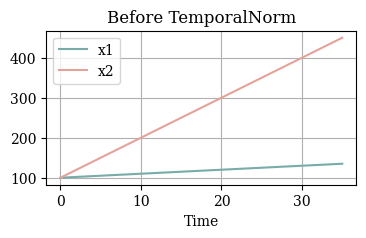

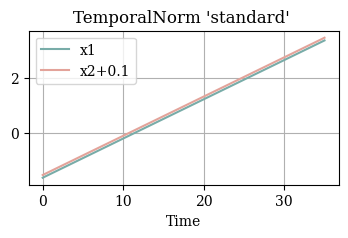

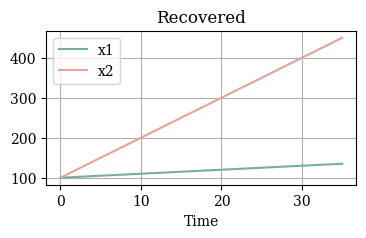

In [32]:
# Validate scalers
x = 1.0*torch.tensor(np_x)
mask = torch.tensor(np_mask)
scaler = TemporalNorm(scaler_type='standard', dim=1)
x_scaled = scaler.transform(x=x, mask=mask)
x_recovered = scaler.inverse_transform(x_scaled)

plt.plot(x[0,:,0], label='x1', color='#78ACA8')
plt.plot(x[0,:,1], label='x2',  color='#E3A39A')
plt.title('Before TemporalNorm')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.plot(x_scaled[0,:,0], label='x1', color='#78ACA8')
plt.plot(x_scaled[0,:,1]+0.1, label='x2+0.1', color='#E3A39A')
plt.title(f'TemporalNorm \'{scaler.scaler_type}\' ')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.plot(x_recovered[0,:,0], label='x1', color='#78ACA8')
plt.plot(x_recovered[0,:,1], label='x2', color='#E3A39A')
plt.title('Recovered')
plt.xlabel('Time')
plt.legend()
plt.show()

In [33]:
#| hide

# Validate scalers
for scaler_type in ['identity', 'standard', 'robust', 'minmax', 'minmax1', 'invariant']:
    x = 1.0*torch.tensor(np_x)
    mask = torch.tensor(np_mask)
    scaler = TemporalNorm(scaler_type=scaler_type, dim=1)
    x_scaled = scaler.transform(x=x, mask=mask)
    x_recovered = scaler.inverse_transform(x_scaled)
    assert torch.allclose(x, x_recovered, atol=1e-5), f'Recovered data is not the same as original with {scaler_type}'